<a href="https://colab.research.google.com/github/dahenderson98/ImageClassifier/DNN_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to CNNs and DNNs

## Objectives

* Build and train a deep conv net
* Explore and implement various initialization techniques
* Implement a parameterized module in Pytorch
* Use a principled loss function
___


In [ ]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [ ]:
# Use the dataset class you created in lab2
class FashionMNISTProcessedDataset(Dataset):
  def __init__(self, root, train=True):
    self.data = datasets.FashionMNIST(root, train=train, 
                                      transform=transforms.ToTensor(), 
                                      download=True)
    
  def __getitem__(self, i):
    x, y = self.data[i]
    return x, y

  def __len__(self):
    return len(self.data)


___

### Part 1
Re-implement a Conv2D module with parameters and a CrossEntropy loss function.

**TODO:**

* CrossEntropyLoss 
* Conv2D

**DONE:**

___

### Part 2
Implement a few initialization strategies which can include Xe initialization
(sometimes called Xavier), Orthogonal initialization, and uniform random.
You can specify which strategy you want to use with a parameter. 



Helpful links include:
*  [Orthogonal Initialization](https://hjweide.github.io/orthogonal-initialization-in-convolutional-layers) (or the original paper: http://arxiv.org/abs/1312.6120)
*  http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization

**TODO:**
* Parameterize custom Conv2D for different initilization strategies
* Xe
* Orthogonal
* Uniform

**DONE:**

Done

In [ ]:
from math import nan
class CrossEntropyLoss(nn.Module):
  def __init__(self):
    super(CrossEntropyLoss, self).__init__()

  def forward(self, y_hat, y):
    t = 10
    y_hat = y_hat / t
    softmax = torch.div( torch.exp(y_hat), torch.sum(torch.exp(y_hat), 1).reshape(-1,1) )
    r = torch.arange(y_hat.size(0))
    observations = softmax[r,y]
    logs = -torch.log(observations)
    loss = torch.sum(logs)

    return loss

class Conv2d(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None, init_type='uniform'):
    self.__dict__.update(locals())
    super(Conv2d, self).__init__()

    self.weight = Parameter(torch.Tensor(out_channels, 
                               in_channels, 
                               *kernel_size))
    self.bias = Parameter(torch.Tensor(out_channels))

    if init_type == 'uniform':
      self.weight.data.uniform_(-1,1)
      self.bias.data.uniform_(0,0)
    elif init_type == 'xe':
      X = np.random.normal(loc=0,scale=np.sqrt(1/in_channels),size=(out_channels, in_channels, *kernel_size))
      Wtesnor = torch.from_numpy(X)
      self.weight.data = Wtesnor.type(torch.FloatTensor)
      B = np.zeros(out_channels)
      B = B.astype(float)
      btensor = torch.from_numpy(B)
      self.bias.data = btensor.type(torch.FloatTensor)
    elif init_type == 'orthogonal':
      X = np.random.random((out_channels, in_channels, *kernel_size))
      U, _, Vt = np.linalg.svd(X, full_matrices=False)
      W = Vt.reshape((out_channels, in_channels, *kernel_size))
      W = W.astype(float)
      Wtesnor = torch.from_numpy(W)
      self.weight.data = Wtesnor.type(torch.FloatTensor)
      B = np.zeros(out_channels)
      B = B.astype(float)
      btensor = torch.from_numpy(B)
      self.bias.data = btensor.type(torch.FloatTensor)

  def forward(self, x):
    return F.conv2d(x, self.weight, self.bias, self.stride, 
                    self.padding, self.dilation, self.groups)


In [ ]:
class ConvNetwork(nn.Module):
  def __init__(self, dataset):
    super(ConvNetwork, self).__init__()
    x, y = dataset[0]
    c, h, w = x.size()
    output = 40

    self.net = nn.Sequential(
        Conv2d(c, 40, (3,3), padding=(1,1), init_type='xe'),
        nn.ReLU(),
        Conv2d(40, 40, (3,3), padding=(1,1), init_type='orthogonal'),
        nn.ReLU(),
        Conv2d(40, 40, (3,3), padding=(1,1), init_type='xe'),
        nn.ReLU(),
        Conv2d(40, 10, (28,28), padding=(0,0), init_type='orthogonal')
    )


  def forward(self, x):
    return self.net(x).squeeze(2).squeeze(2)


In [ ]:
# Initialize Datasets
train_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=True)
val_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=False)

# Initialize DataLoaders
train_loader = DataLoader(train_dataset, batch_size=42, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=42)

In [ ]:
# Initialize Model
model = ConvNetwork(train_dataset)
model = model.cuda()

# Initialize Objective and Optimizer and other parameters
optimizer = optim.Adam(model.parameters(), lr=1e-4)
objective = CrossEntropyLoss()

losses = []
validations = []
train_ac_x = []
accuracies = []
val_accuracies = []

# Run your training and validation loop and collect stats
for epoch in range(1):
  loop = tqdm(total=len(train_loader), position=0, leave=False)

  for batch, (x, y_truth) in enumerate(train_loader):
    x, y_truth = x.cuda(non_blocking=True), y_truth.cuda(non_blocking=True)

    optimizer.zero_grad()
    y_hat = model(x)

    loss = objective(y_hat, y_truth)
    loss.backward()

    losses.append(loss.item())
    accuracy = (torch.softmax(y_hat,1).argmax(1) == y_truth).float().mean()
    train_ac_x.append(len(accuracies))
    accuracies.append(accuracy.cpu())
    loop.set_description('epoch:{}, loss:{:.4f}, accuracy:{:.3f}'.format(epoch, loss, accuracy))
    loop.update(1)

    optimizer.step()

    if batch % 250 == 0 or batch == 1400:
      val = np.mean([objective(model(x.cuda()), y.cuda()).item()
                     for x, y in val_loader])
      validations.append((len(losses), val))
      val_ac = torch.FloatTensor([ (torch.softmax(model(x.cuda()),1).argmax(1) == y.cuda()).float().mean() for x, y in val_loader]).mean()
      val_accuracies.append((batch, val_ac))

  loop.close()

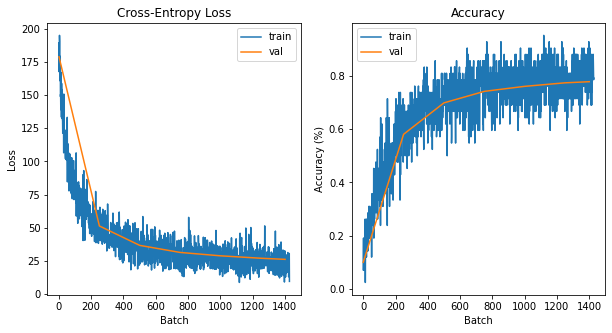

In [ ]:
# CEL plotting

a, b = zip(*validations)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
_ = ax1.plot(losses, label='train')
_ = ax1.plot(a, b, label='val')
_ = ax1.set_title("Cross-Entropy Loss")
_ = ax1.set_xlabel("Batch")
_ = ax1.set_ylabel("Loss")
_ = ax1.legend()

# Accuracy plotting

a_val_ac, b_val_ac = zip(*val_accuracies)

_ = ax2.set_title("Accuracy")
_ = ax2.set_xlabel("Batch")
_ = ax2.set_ylabel("Accuracy (%)")
_ = ax2.plot(train_ac_x, accuracies, label='train')
_ = ax2.plot(a_val_ac, b_val_ac, label='val')
_ = ax2.legend()

In [ ]:
model = ConvNetwork(train_dataset)
model.net[0].weight.data.uniform_(-1,1)

W = np.random.randn(*model.net[0].weight.size())
model.net[0].weight.data = torch.from_numpy(W)
model.net[0].weight.data

In [ ]:
a = torch.from_numpy(np.random.randn(3,10,1).astype(np.float32)).cuda()
a

In [ ]:
b = torch.exp(a).cuda(non_blocking=True)
i = y_truth[:3]
r = torch.arange(b.size(0)).cuda(non_blocking=True)
c = i
b[r,c]

In [ ]:
r,c

In [ ]:
z = a / b.sum(1, keepdim=True)
z.size()

In [ ]:
(torch.softmax(y_hat,1).argmax(1) == y_truth).float().mean()

In [ ]:
# Check GPU usage stats
!nvidia-smi

In [ ]:
# Test conv dimension transformation
#(c=3, h=10, w=10) => (c=10, h=8, w=8) : out=10, kernel_size=(3,3), padding=(0,0)

c = nn.Conv2d(3, 10, kernel_size=(3,3), padding=(0,0))
c(torch.zeros(1,3,10,10)).size()


___

### Part 3
Print the number of parameters in your network and plot accuracy of your training and validation 
set over time. You should experiment with some deep networks and see if you can get a network 
with close to 1,000,000 parameters.

Once you've experimented with multiple network setups and the different initialization strategies, plot the best-performing experiment here. You should be able to exceed 85% accuracy on the validation set.

**TODO:**
* Experiment with Deep Networks
* Plot accuracy of training and validation set over time
* Print out number of parameters in the model 
* Plot experiment results with 85% or better validation accuracy

**DONE:**

Done


In [ ]:

# Go back up and try a few different networks and initialization strategies
# Plot loss if you want
# Plot accuracy



In [ ]:
# Compute and print the number of parameters in the model
params = 0
for p in model.parameters():
  block = p.size(0)
  for i in range(1,len(p.size())):
    block *= p.size(i)
  params+= block

print(f"Parameters: {params}")

Parameters: 342890


___

### Part 4
Learn about how convolution layers affect the shape of outputs, and answer the following quiz questions. Include these in a new markdown cell in your jupyter notebook.


*Using a Kernel size of 3×3 what should the settings of your 2d convolution be that results in the following mappings (first answer given to you)*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(3, 3), padding=(0, 0))
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **(out_channels=22, kernel_size=(3, 3), padding=(1, 1))**
* (c=3, h=10, w=10) ⇒ (c=65, h=12, w=12) : **(out_channels=65, kernel_size=(3, 3), padding=(2, 2))**
* (c=3, h=10, w=10) ⇒ (c=7, h=20, w=20) : **(out_channels=7, kernel_size=(3, 3), padding=(6, 6))**

*Using a Kernel size of 5×5:*)

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 5), padding=(1, 1))
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **(out_channels=100, kernel_size=(5, 5), padding=(2, 2))**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **(out_channels=23, kernel_size=(5, 5), padding=(3, 3))**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **(out_channels=5, kernel_size=(5, 5), padding=(9, 9))**

*Using Kernel size of 5×3:*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : **(out_channels=10, kernel_size=(5, 3), padding=(1, 0))**
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **(out_channels=100, kernel_size=(5, 3), padding=(2, 1))**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **(out_channels=23, kernel_size=(5, 3), padding=(3, 2))**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **(out_channels=5, kernel_size=(5, 3), padding=(9, 8))**

*Determine the kernel that requires the smallest padding size to make the following mappings possible:*

* (c=3, h=10, w=10) ⇒ (c=10, h=9, w=7) : **(out_channels=10, kernel_size=(2, 4), padding=(0, 0))**
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **(out_channels=22, kernel_size=(1, 1), padding=(0, 0))**

**TODO:**

* Answer all the questions above 

**DONE:**

Done


In [ ]:
# Write some test code for checking the answers for these problems (example shown in the video)
c = nn.Conv2d(3, 10, kernel_size=(2,4), padding=(0,0))
c(torch.zeros(1,3,10,10)).size()

torch.Size([1, 10, 9, 7])